L'objectif de ce NB est de vérifier la distribution de la solution du problème de moindres carrés linéaires. Plus précisément, on vérifie que la covariance de la loi gaussienne associée à la méthode `getParameterPosterior` est correcte pour la classe `GaussianLinearCalibration`.

On considère ici un modèle *exactement* linéaire. On essaye de calculer l'estimateur MAP par une décomposition de Cholesky puis de calculer la matrice de covariance.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

In [2]:
ot.RandomGenerator.SetSeed(0)

In [3]:
def modelLineaire(X):
    x,theta1,theta2,theta3 = X
    y = theta1 + theta2*x + theta3*x**2
    return [y]

In [4]:
g = ot.PythonFunction(4, 1, modelLineaire) 

In [5]:
descr = ["Theta1", "Theta2", "Theta3"]

In [6]:
trueParameter = ot.Point([11.11,6.6,-9.9])
trueParameter

class=Point name=Unnamed dimension=3 values=[11.11,6.6,-9.9]

In [7]:
parameterDimension = trueParameter.getDimension()
parameterDimension

3

Create the joint input distribution function.

In [8]:
X = ot.Uniform()
Theta1 = ot.Dirac(trueParameter[0])
Theta2 = ot.Dirac(trueParameter[1])
Theta3 = ot.Dirac(trueParameter[2])

X.setDescription(["X"])
Theta1.setDescription(["Theta1"])
Theta2.setDescription(["Theta2"])
Theta3.setDescription(["Theta3"])

inputRandomVector = ot.ComposedDistribution([X, Theta1, Theta2, Theta3])

In [9]:
calibratedIndices = [1,2,3]
model = ot.ParametricFunction(g, calibratedIndices, trueParameter)

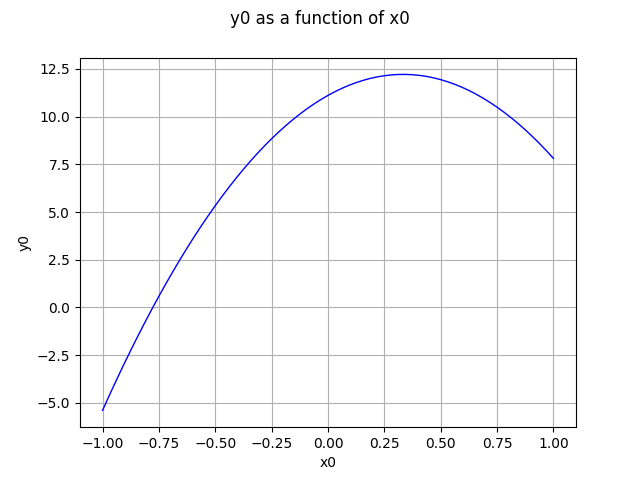

In [10]:
model.draw(-1,1)

Generate observation noise.

In [11]:
outputObservationNoiseSigma = 2. # (Pa)
observationOutputNoise = ot.Normal(0.,outputObservationNoiseSigma)

## Gaussian linear calibration

Define the covariance matrix of the output Y of the model.

In [12]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0,0] = outputObservationNoiseSigma**2
errorCovariance

class=CovarianceMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[4]

Defined the covariance matrix of the parameters $\theta$ to calibrate.

In [13]:
sigmaTheta1 = 0.1 * trueParameter[0]
sigmaTheta2 = 0.1 * trueParameter[1]
sigmaTheta3 = 0.1 * trueParameter[2]

In [14]:
parameterCovariance = ot.CovarianceMatrix(3)
parameterCovariance[0,0] = sigmaTheta1**2
parameterCovariance[1,1] = sigmaTheta2**2
parameterCovariance[2,2] = sigmaTheta3**2
parameterCovariance

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1.23432,0,0,0,0.4356,0,0,0,0.9801]

In [15]:
size = 500

In [16]:
# 1. Generate exact outputs
inputSample = inputRandomVector.getSample(size)
outputStress = g(inputSample)
# 2. Add noise
sampleNoiseH = observationOutputNoise.getSample(size)
outputObservations = outputStress + sampleNoiseH
# 3. Calibrate
inputObservations = inputSample[:,0]

In [17]:
candidate = ot.Point([12.,7.,-8])
candidate

class=Point name=Unnamed dimension=3 values=[12,7,-8]

## Analysis of the results

In [18]:
def GaussianLinearCalibrationCompute(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance):
    '''Use GaussianLinearCalibration'''
    algo = ot.GaussianLinearCalibration(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance)
    algo.run()
    calibrationResult = algo.getResult()
    thetaStar = calibrationResult.getParameterMAP()
    thetaPosterior = calibrationResult.getParameterPosterior()
    covarianceThetaStar = thetaPosterior.getCovariance()
    return thetaStar, covarianceThetaStar

In [19]:
def GaussianNonLinearCalibrationCompute(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance):
    '''Use GaussianNonLinearCalibration'''
    algo = ot.GaussianNonLinearCalibration(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance)
    algo.run()
    calibrationResult = algo.getResult()
    thetaStar = calibrationResult.getParameterMAP()
    thetaPosterior = calibrationResult.getParameterPosterior()
    covarianceThetaStar = thetaPosterior.getCovariance()
    return thetaStar, covarianceThetaStar

## Calibration based on Kalman matrix

In [20]:
def ComputeFromKalman(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance):
    '''Compute the solution from the Kalman matrix'''
    parameterDimension = candidate.getDimension()
    size = inputObservations.getSize()
    #
    model.setParameter(candidate)
    modelObservations = model(inputObservations)
    #
    deltay = outputObservations - modelObservations
    deltay = deltay.asPoint()
    # Compute J
    transposedGradientObservations = ot.Matrix(parameterDimension,size)
    for i in range(size):
        g = model.parameterGradient(inputObservations[i])
        transposedGradientObservations[:,i] = g
    gradientObservations = transposedGradientObservations.transpose()
    #
    B = ot.CovarianceMatrix(parameterCovariance)
    IB = ot.IdentityMatrix(parameterDimension)
    invB = B.solveLinearSystem(IB)
    #
    R = ot.CovarianceMatrix(size)
    for i in range(size):
        R[i,i] = errorCovariance[0,0]
    IR = ot.IdentityMatrix(size)
    invR = R.solveLinearSystem(IR)
    #
    C = gradientObservations.transpose() * invR
    invA = invB + C * gradientObservations
    K = invA.solveLinearSystem(C)
    thetaStar = candidate + K * deltay
    #
    L = IB - K * gradientObservations
    covarianceThetaStar = K * R * K.transpose() + L * B * L.transpose()
    return thetaStar, covarianceThetaStar

In [21]:
def ComputeFromLinearLeastSquaresCholesky(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance):
    parameterDimension = candidate.getDimension()
    size = inputObservations.getSize()
    #
    model.setParameter(candidate)
    modelObservations = model(inputObservations)
    #
    deltay = outputObservations - modelObservations
    deltay = deltay.asPoint()
    # Create B, R, inv(B), inv(R)
    B = ot.CovarianceMatrix(parameterCovariance)
    R = ot.CovarianceMatrix(size)
    for i in range(size):
        R[i,i] = errorCovariance[0,0]
    LB = B.computeCholesky()
    LR = R.computeCholesky()
    # Compute J
    transposedGradientObservations = ot.Matrix(parameterDimension,size)
    for i in range(size):
        g = model.parameterGradient(inputObservations[i])
        transposedGradientObservations[:,i] = g
    gradientObservations = transposedGradientObservations.transpose()
    #
    ILB = ot.IdentityMatrix(parameterDimension)
    invLB = LB.solveLinearSystem(ILB)
    invLRJ = LR.solveLinearSystem(gradientObservations)
    llsqA = ot.Matrix(size+parameterDimension,parameterDimension)
    llsqA[0:parameterDimension,0:parameterDimension] = invLB
    llsqA[parameterDimension:size+parameterDimension,0:parameterDimension] = llsqA[parameterDimension:size+parameterDimension,0:parameterDimension]-invLRJ
    invLRz = LR.solveLinearSystem(deltay)
    y = ot.Point(size+parameterDimension)
    y[parameterDimension:size+parameterDimension] = y[parameterDimension:size+parameterDimension]-invLRz
    method = ot.SVDMethod(llsqA)
    deltaTheta = method.solve(y)
    thetaStar = deltaTheta + candidate
    return thetaStar

In [22]:
def ComputeCovarianceFromWoodbury(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance):
    parameterDimension = candidate.getDimension()
    size = inputObservations.getSize()
    #
    model.setParameter(candidate)
    modelObservations = model(inputObservations)
    #
    B = ot.CovarianceMatrix(parameterCovariance)
    R = ot.CovarianceMatrix(size)
    for i in range(size):
        R[i,i] = errorCovariance[0,0]
    # Compute J
    transposedGradientObservations = ot.Matrix(parameterDimension,size)
    for i in range(size):
        g = model.parameterGradient(inputObservations[i])
        transposedGradientObservations[:,i] = g
    gradientObservations = transposedGradientObservations.transpose()
    #
    JB = gradientObservations*B
    covarianceThetaStar = B - JB.transpose()*(R+JB*transposedGradientObservations)*JB
    return covarianceThetaStar

In [23]:
def ComputeFromKalmanSimple(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance):
    '''Compute the solution from the Kalman matrix'''
    parameterDimension = candidate.getDimension()
    size = inputObservations.getSize()
    #
    model.setParameter(candidate)
    modelObservations = model(inputObservations)
    #
    deltay = outputObservations - modelObservations
    deltay = deltay.asPoint()
    # Compute J
    transposedGradientObservations = ot.Matrix(parameterDimension,size)
    for i in range(size):
        g = model.parameterGradient(inputObservations[i])
        transposedGradientObservations[:,i] = g
    gradientObservations = transposedGradientObservations.transpose()
    #
    B = ot.CovarianceMatrix(parameterCovariance)
    IB = ot.IdentityMatrix(parameterDimension)
    invB = B.solveLinearSystem(IB)
    #
    R = ot.CovarianceMatrix(size)
    for i in range(size):
        R[i,i] = errorCovariance[0,0]
    IR = ot.IdentityMatrix(size)
    invR = R.solveLinearSystem(IR)
    #
    C = gradientObservations.transpose() * invR
    invA = invB + C * gradientObservations
    K = invA.solveLinearSystem(C)
    thetaStar = candidate + K * deltay
    #
    L = IB - K * gradientObservations
    covarianceThetaStar = L * B
    return thetaStar, covarianceThetaStar

## GaussianLinearCalibrationCompute

In [24]:
thetaStar, covarianceThetaStar = GaussianLinearCalibrationCompute(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance)

In [25]:
thetaStar

class=Point name=Unnamed dimension=3 values=[10.9745,6.61909,-9.23324]

In [26]:
covarianceThetaStar

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.0168322,0.0003082,-0.0261941,0.0003082,0.0222599,-6.12752e-05,-0.0261941,-6.12752e-05,0.0772671]

## GaussianNonLinearCalibrationCompute

In [32]:
thetaStar, covarianceThetaStar = GaussianNonLinearCalibrationCompute(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance)

In [33]:
thetaStar

class=Point name=Unnamed dimension=3 values=[10.9745,6.61909,-9.23324]

In [34]:
covarianceThetaStar

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.0219515,-0.000118445,-0.0300531,-0.000118445,0.0223291,-0.0021027,-0.0300531,-0.0021027,0.112363]

## Kalman

In [27]:
thetaStar, covarianceThetaStar = ComputeFromKalman(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance)
thetaStar

class=Point name=Unnamed dimension=3 values=[10.9745,6.61909,-9.23324]

In [28]:
covarianceThetaStar

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.0168322,0.0003082,-0.0261941,0.0003082,0.0222599,-6.12752e-05,-0.0261941,-6.12752e-05,0.0772671]

In [29]:
thetaStar = ComputeFromLinearLeastSquaresCholesky(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance)
thetaStar

class=Point name=Unnamed dimension=3 values=[10.9745,6.61909,-9.23324]

## Par la formule de Woodbury

In [30]:
covarianceThetaStar = ComputeCovarianceFromWoodbury(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance)
covarianceThetaStar

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[-516669,2615.06,-149547,2615.06,-2545.23,744.023,-149547,744.023,-45396.4]

In [31]:
thetaStar, covarianceThetaStar = ComputeFromKalman(model, inputObservations, outputObservations, \
    candidate, parameterCovariance, errorCovariance)
covarianceThetaStar

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.0168322,0.0003082,-0.0261941,0.0003082,0.0222599,-6.12752e-05,-0.0261941,-6.12752e-05,0.0772671]